<a href="https://colab.research.google.com/github/iotpelican/ml-llm-course-work/blob/main/ss_T27_Class_Project_school_drop_prediction_4_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title Cell 1: Setup, Data Loading, and Kaggle API
# This cell handles all the setup, but requires a few manual steps to use the Kaggle API.
#
# **Step 1: Get your Kaggle API Token**
# * Log in to your Kaggle account (or create one).
# * Go to your account settings (`Account` tab in your profile).
# * Scroll down to the "API" section and click "Create New Token". This will download a file named `kaggle.json`.
#
# **Step 2: Upload the API Token to Colab**
# * On the left side of your Colab window, click the folder icon to open the file browser.
# * Click the "Upload" button (the file icon with an arrow pointing up) and upload the `kaggle.json` file you just downloaded.
#
# **Step 3: Run this cell**

# Install the necessary packages
!pip install -q kaggle
!pip install -q scikit-learn
!pip install -q xgboost
!pip install -q matplotlib
!pip install -q seaborn

# Set up Kaggle API token path
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

# Import core libraries and machine learning modules
import pandas as pd
import numpy as np

# Core machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # Use the Kaggle API to download the dataset
    print("Downloading dataset from Kaggle...")
    !kaggle datasets download -d thedevastator/higher-education-predictors-of-student-retention --unzip

    # Load the dataset from the downloaded CSV file
    df = pd.read_csv('dataset.csv')

    # Separate features and target
    X = df.drop('Target', axis=1)
    y = df['Target']

    # Display basic info to confirm success
    print("Dataset successfully loaded!")
    print("Dataset shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nFirst 5 rows of the combined DataFrame:")
    print(df.head())

except Exception as e:
    print(f"An error occurred while fetching the dataset: {e}")
    print("Please make sure you have uploaded your kaggle.json file to Colab.")


Dataset URL: https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention
License(s): CC0-1.0
  0% 0.00/87.2k [00:00<?, ?B/s]
100% 87.2k/87.2k [00:00<00:00, 193MB/s]
Dataset successfully loaded!
Dataset shape: (4424, 35)
Columns: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem

In [9]:
# @title Cell 2: Data Preprocessing and Feature Engineering
# This cell handles missing values, identifies categorical and numerical columns,
# and prepares the data for machine learning models using one-hot encoding for
# categorical features and standard scaling for numerical features. We also
# encode the target variable (`y`).

# Handle missing values by filling them with the mode for each column
# This is a simple approach, but a good starting point.
X = X.fillna(X.mode().iloc[0])

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Mapping for marital status numerical codes
marital_status_map = {
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto union',
    6: 'Legally separated'
}

# Create a new column with the descriptive text labels
df['Marital status (text)'] = df['Marital status'].map(marital_status_map)

# Create preprocessing pipelines for numerical and categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
target_names = label_encoder.classes_

print("Data preprocessed and features identified!")
print(f"Categorical columns ({len(categorical_cols)}):", list(categorical_cols))
print(f"Numerical columns ({len(numerical_cols)}):", list(numerical_cols))
print(f"Target classes encoded as: {list(zip(target_names, sorted(np.unique(y_encoded))))}")


Data preprocessed and features identified!
Categorical columns (0): []
Numerical columns (34): ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Infla

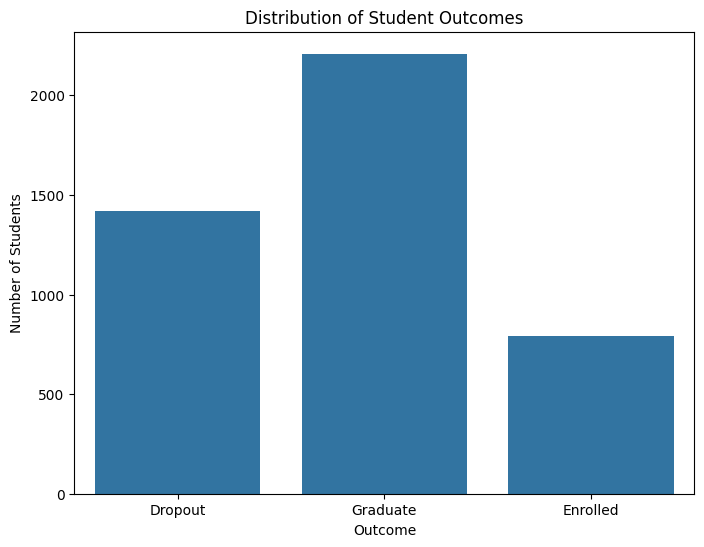

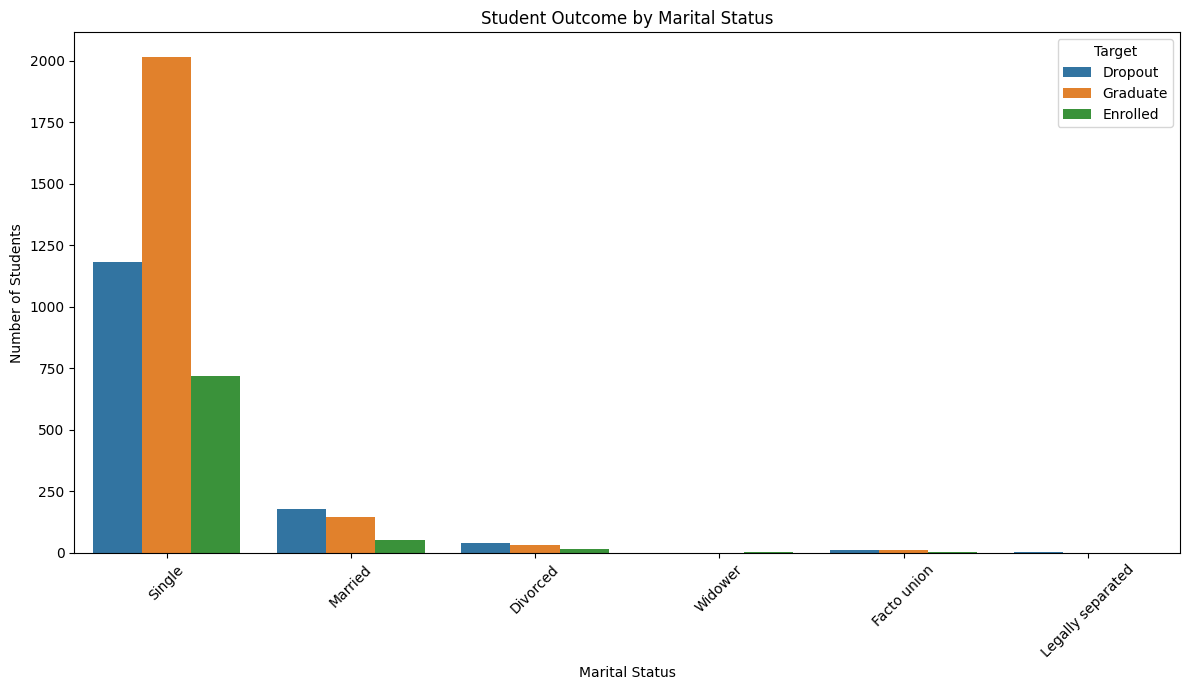

In [11]:
# @title Cell 3: Exploratory Data Analysis (EDA)
# This cell provides a quick look at the data through visualizations. We'll plot
# the distribution of the target variable and a few key features to gain initial insights.

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Target')
plt.title('Distribution of Student Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Number of Students')
plt.show()

# Plot relationship between 'Marital status' and 'Target' using the new text column
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Marital status (text)', hue='Target')
plt.title('Student Outcome by Marital Status')
plt.xticks(rotation=45)
plt.xlabel('Marital Status')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()



In [12]:
# @title Cell 4: Data Splitting
# We now split the data into training and testing sets. A 80/20 split is a
# common practice, where 80% is used for training the models and 20% for testing
# their performance on unseen data.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (3539, 34)
X_test shape: (885, 34)
y_train shape: (3539,)
y_test shape: (885,)


Logistic Regression Model Evaluation:
Accuracy: 0.7581920903954802

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.79      0.75      0.77       284
    Enrolled       0.50      0.33      0.40       159
    Graduate       0.79      0.92      0.85       442

    accuracy                           0.76       885
   macro avg       0.70      0.67      0.67       885
weighted avg       0.74      0.76      0.74       885



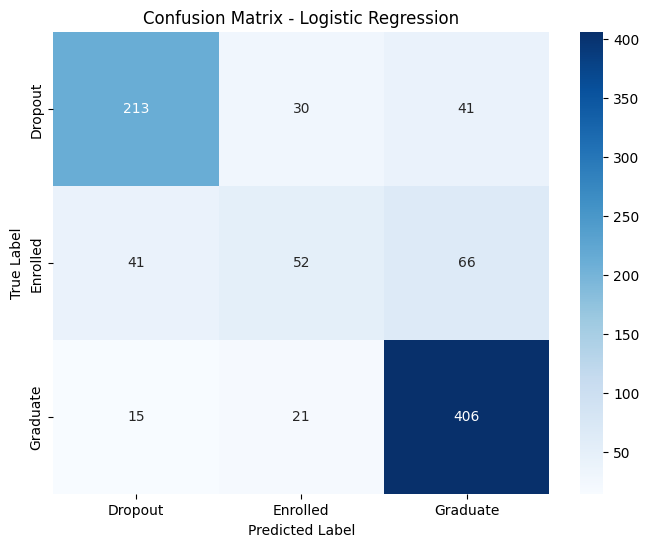

In [13]:
# @title Cell 5: Model Training and Evaluation (Logistic Regression)
# We'll start with Logistic Regression as a baseline model. It's a simple,
# interpretable model that's great for getting a first look at performance.

# Import the classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create a pipeline with the preprocessor and the model
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(max_iter=1000))])

# Train the model
log_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = log_reg_pipeline.predict(X_test)

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=target_names))

# Create a confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [14]:
# @title Cell 6: Model Training and Evaluation (Decision Tree)
# Decision Trees are easy to understand and visualize, and they can capture non-linear
# relationships in the data.

# Import the classifier
from sklearn.tree import DecisionTreeClassifier

# Create a pipeline for the Decision Tree model
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42))])

# Train the model
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate the model
print("Decision Tree Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))


Decision Tree Model Evaluation:
Accuracy: 0.6858757062146893

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.70      0.68      0.69       284
    Enrolled       0.39      0.43      0.41       159
    Graduate       0.80      0.79      0.79       442

    accuracy                           0.69       885
   macro avg       0.63      0.63      0.63       885
weighted avg       0.69      0.69      0.69       885



Random Forest Model Evaluation:
Accuracy: 0.7796610169491526

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.82      0.75      0.78       284
    Enrolled       0.58      0.38      0.46       159
    Graduate       0.80      0.94      0.87       442

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.77      0.78      0.77       885


Top 10 Most Important Features:
                                        feature  importance
28     num__Curricular units 2nd sem (approved)    0.146862
29        num__Curricular units 2nd sem (grade)    0.103916
22     num__Curricular units 1st sem (approved)    0.091930
23        num__Curricular units 1st sem (grade)    0.072925
17                       num__Age at enrollment    0.046114
27  num__Curricular units 2nd sem (evaluations)    0.043693
14                 num__Tuition fees up to date    0.038270
3                    

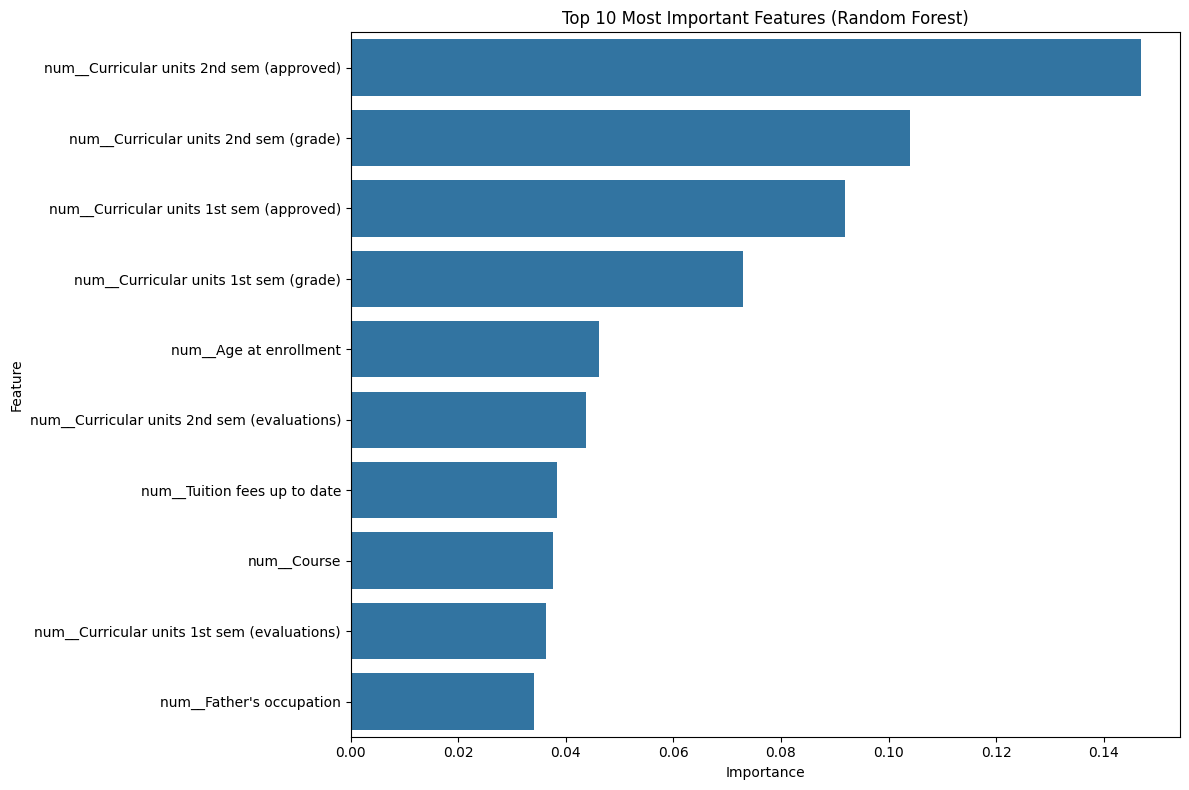

In [15]:
# @title Cell 7: Model Training and Evaluation (Random Forest & Feature Importance)
# Random Forest is an ensemble method that often performs very well. A key benefit is
# its ability to provide a ranked list of feature importances, showing which
# variables were most influential in the predictions.

# Import the classifier
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline for the Random Forest model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate the model
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

# Get feature importances from the trained Random Forest model
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_
preprocessed_features = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame to store feature importance
importance_df = pd.DataFrame({
    'feature': preprocessed_features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [16]:
# @title Cell 8: Model Training and Evaluation (XGBoost)
# XGBoost is a powerful gradient boosting algorithm that is highly effective for
# structured data and often provides top-tier performance.

# Import the classifier
import xgboost as xgb

# Create a pipeline for the XGBoost model
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate the model
print("XGBoost Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=target_names))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:46:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Evaluation:
Accuracy: 0.7627118644067796

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.81      0.74      0.77       284
    Enrolled       0.51      0.43      0.47       159
    Graduate       0.81      0.89      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.75      0.76      0.76       885



In [17]:
# @title Cell 9: Performance Summary
# This final cell summarizes the performance of all models side-by-side for easy comparison.

# Create a dictionary to store the results
results = {
    'Model': [],
    'Accuracy': [],
    'Precision (Macro)': [],
    'Recall (Macro)': [],
    'F1-Score (Macro)': []
}

# Define a function to evaluate and store results for each model
def evaluate_and_store(model_name, y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy_score(y_true, y_pred))
    results['Precision (Macro)'].append(report['macro avg']['precision'])
    results['Recall (Macro)'].append(report['macro avg']['recall'])
    results['F1-Score (Macro)'].append(report['macro avg']['f1-score'])

# Populate the results dictionary
evaluate_and_store('Logistic Regression', y_test, y_pred_lr)
evaluate_and_store('Decision Tree', y_test, y_pred_dt)
evaluate_and_store('Random Forest', y_test, y_pred_rf)
evaluate_and_store('XGBoost', y_test, y_pred_xgb)

# Create a DataFrame for a clean summary
results_df = pd.DataFrame(results).set_index('Model')

print("Model Performance Summary:")
print(results_df)

Model Performance Summary:
                     Accuracy  Precision (Macro)  Recall (Macro)  \
Model                                                              
Logistic Regression  0.758192           0.696033        0.665199   
Decision Tree        0.685876           0.628265        0.629599   
Random Forest        0.779661           0.732862        0.691608   
XGBoost              0.762712           0.709347        0.690195   

                     F1-Score (Macro)  
Model                                  
Logistic Regression          0.672517  
Decision Tree                0.628492  
Random Forest                0.703179  
XGBoost                      0.697478  
